In [8]:
from matplotlib import style, pylab
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import datetime

from collections import Counter

from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import bs4 as bs
import pickle
import requests

import datetime as dt
import os 
import sys

pylab.rcParams['figure.figsize'] = (15, 10)
style.use('ggplot')


In [3]:
def save_sp500_tickers():
    resp = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = bs.BeautifulSoup(resp.text,"lxml")
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers = []
    
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    
    with open("sp500.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

In [4]:
ans = save_sp500_tickers()

In [14]:
print datetime.date.today()

2017-05-06


In [19]:
def get_stocks_from_sp500(reload_st=False):
    # Reloads data if needed
    if reload_st:
        tickers = save_sp500_tickers()
    else:
        with open("sp500.pickle","rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists("stock_dfs"):
        os.makedirs("stock_dfs")
    
    today = datetime.date.today()
    start = dt.datetime(2000,1,1)
    stop = dt.datetime(today[0],today[1],today[2])
    
    for ticker in tickers:
        if not os.path.exists("stock_dfs/{}.csv".format(ticker)) or reload_st:
            try:
                df = web.DataReader(ticker, 'yahoo', start, stop)
                df.to_csv("stock_dfs/{}.csv".format(ticker))
                print ticker
            except:
                e = sys.exc_info()[0]
                print "err",e
        else:
            print("Already have: {}".format(ticker))
            

In [20]:
get_stocks_from_sp500(True)

TypeError: 'datetime.date' object has no attribute '__getitem__'

In [27]:
def add_ma(df):
    df['25ma'] = df["Adj Close"].rolling(window=25).mean()
    df['50ma'] = df["Adj Close"].rolling(window=50).mean()
    df['100ma'] = df["Adj Close"].rolling(window=100).mean()
    df['200ma'] = df["Adj Close"].rolling(window=200).mean()    
#     df['50fa'] = df["Adj Close"][::-1].rolling(window=50).mean()
#     df['100fa'] = df["Adj Close"][::-1].rolling(window=100).mean()
#     df['200fa'] = df["Adj Close"][::-1].rolling(window=200).mean()

    df['Close_min_Open'] = (df['Close'] - df['Open'])
    df['High_min_Low'] = (df['High'] - df['Low'])    
    df['Close_min_Open_mean'] = df['Close_min_Open'].rolling(150).mean()
    df['High_min_Low_mean'] = df['High_min_Low'].rolling(150).mean()
    
    
    # DROPPING TABLES
    del df['Close_min_Open']
    del df['High_min_Low']
    del df['Close']
    #del df['Close_min_Open_mean']
    
    
    df['Volume'] = df["Volume"].rolling(window=100).sum() #inaccurate

    df.dropna(inplace=True)
    
    df = (df - df.mean()) / (df.max() - df.min()) #inaccurate
#     df['Volume'] = (df['Volume'] - df['Volume'].mean()) / (df['Volume'].max() - df['Volume'].min()) #inaccurate
    
    
    return df

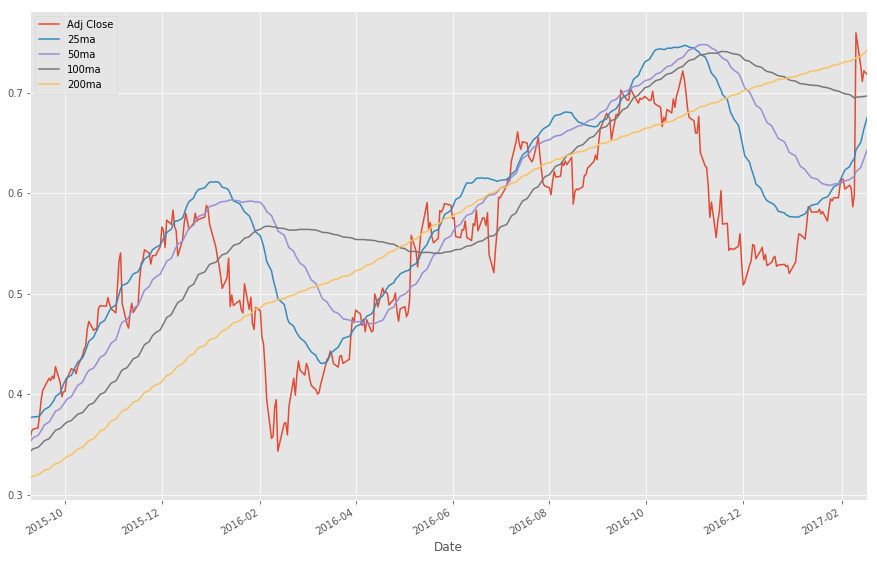

In [29]:
df = pd.read_csv('stock_dfs/ATVI.csv',parse_dates=True,index_col=0)
df = add_ma(df)
df[["Adj Close","25ma","50ma","100ma","200ma"]][-365:].plot()
# df["High_min_Low_mean"][-365:].plot()
# df.plot()
plt.show()

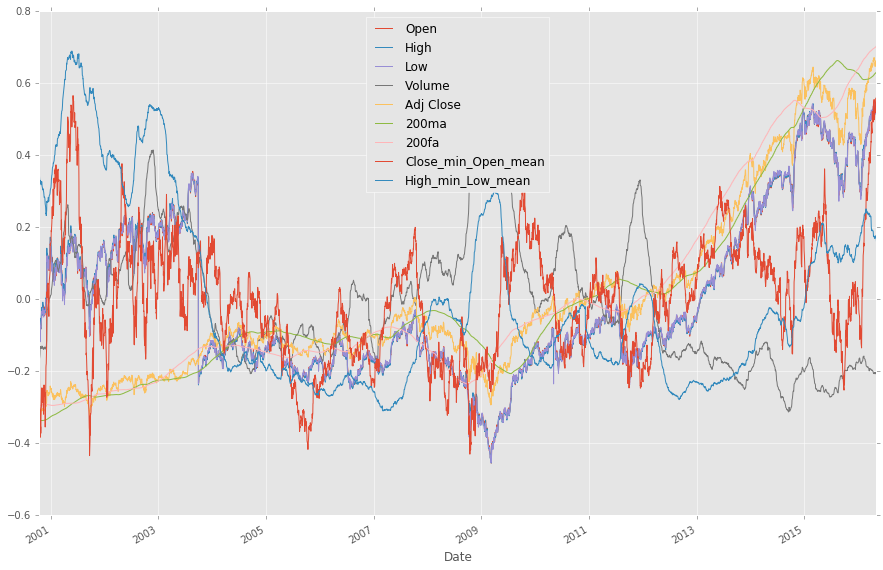

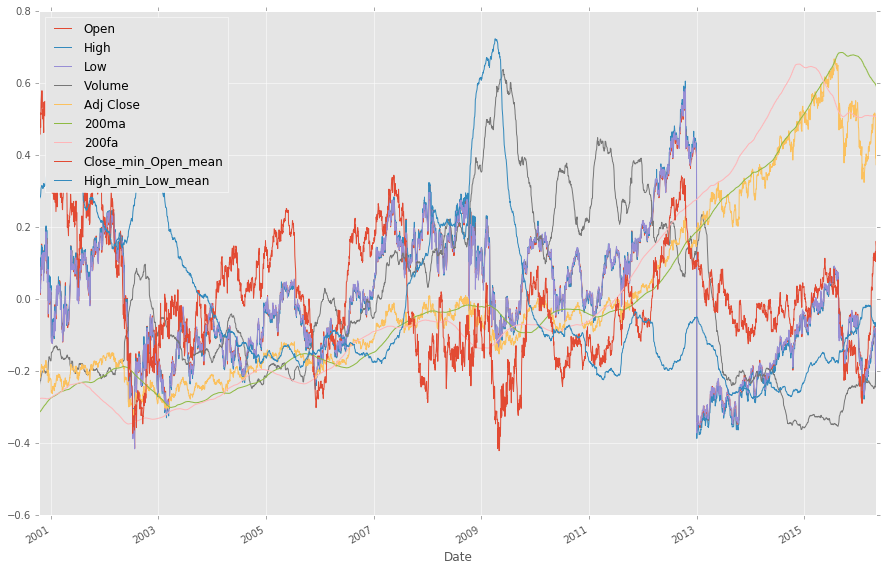

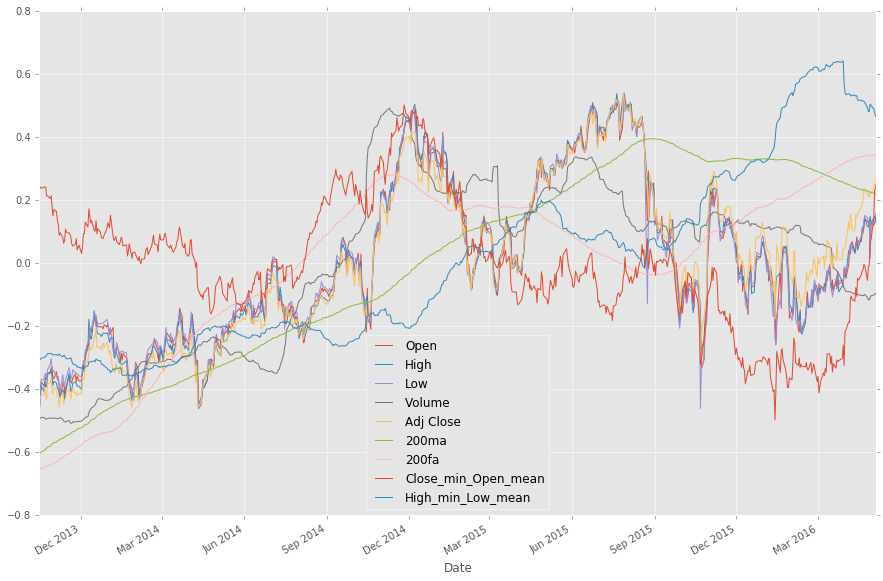

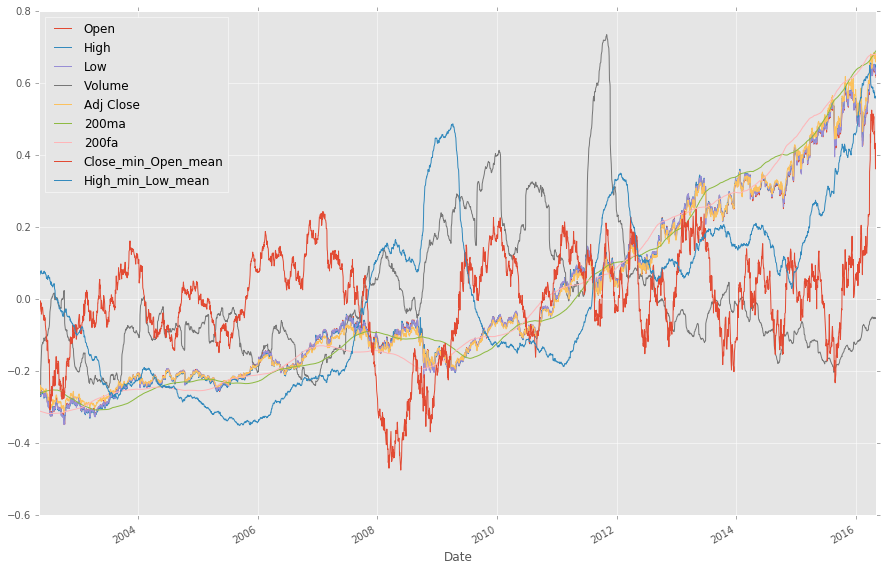

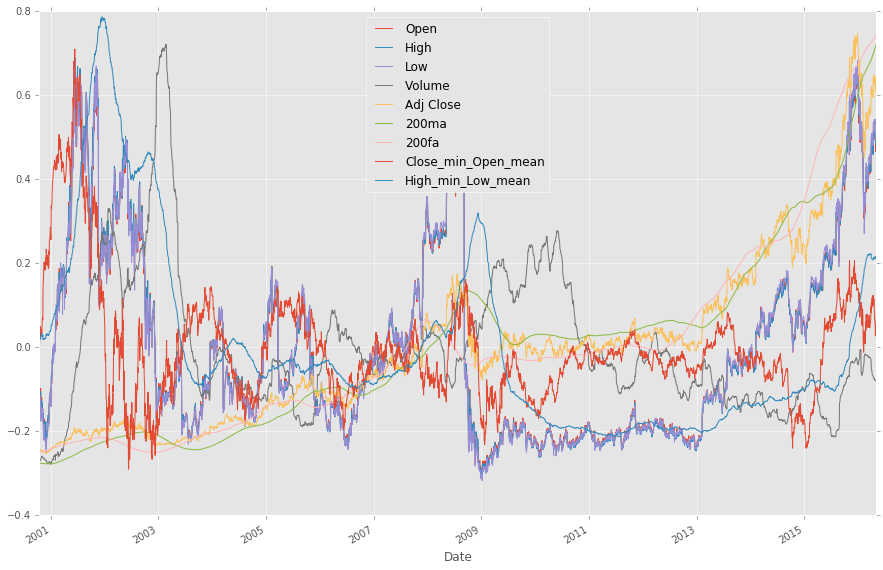

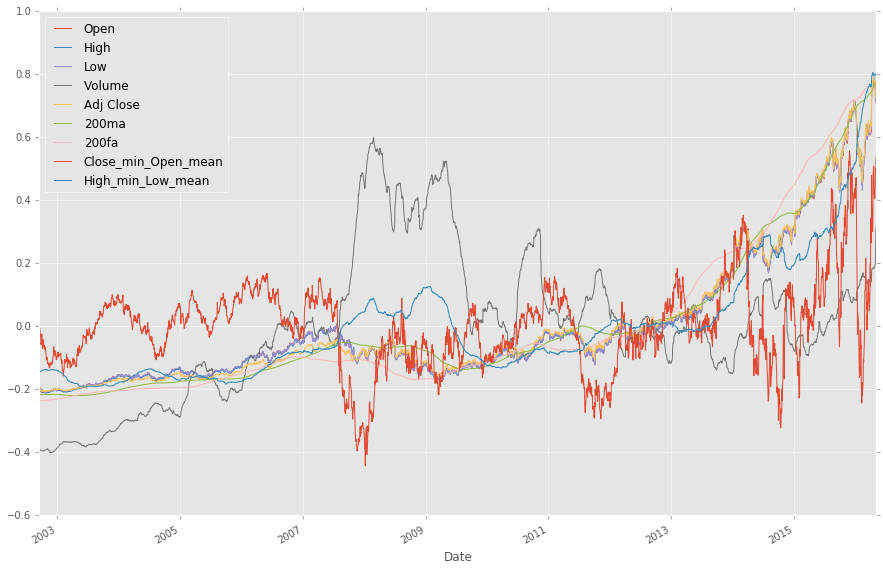

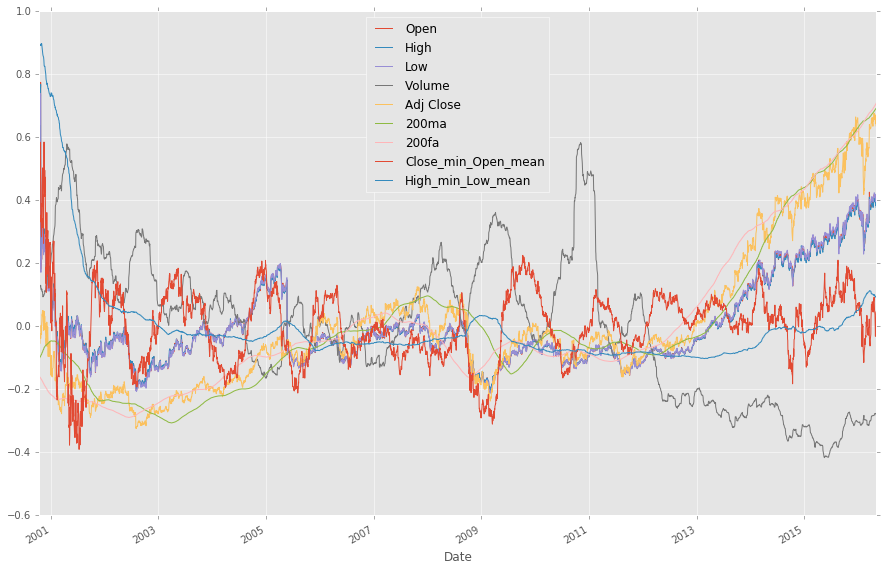

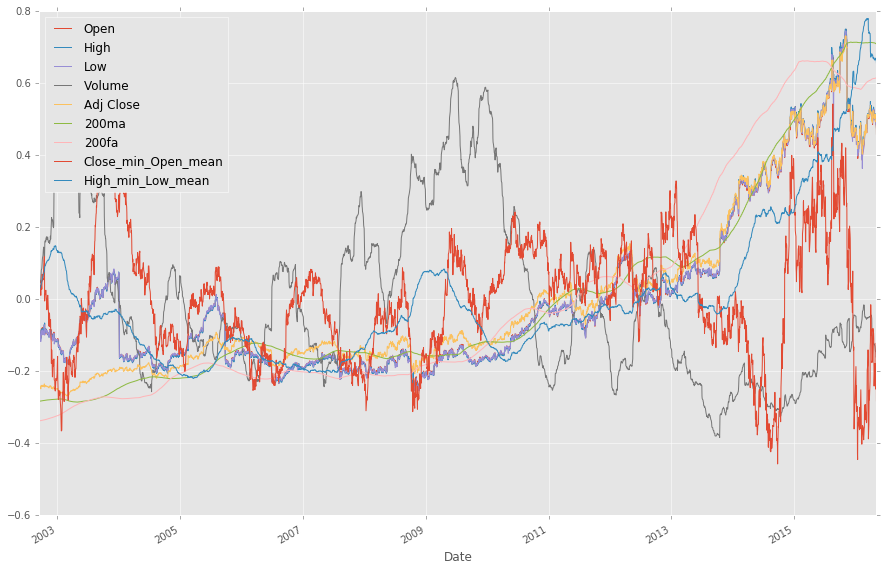

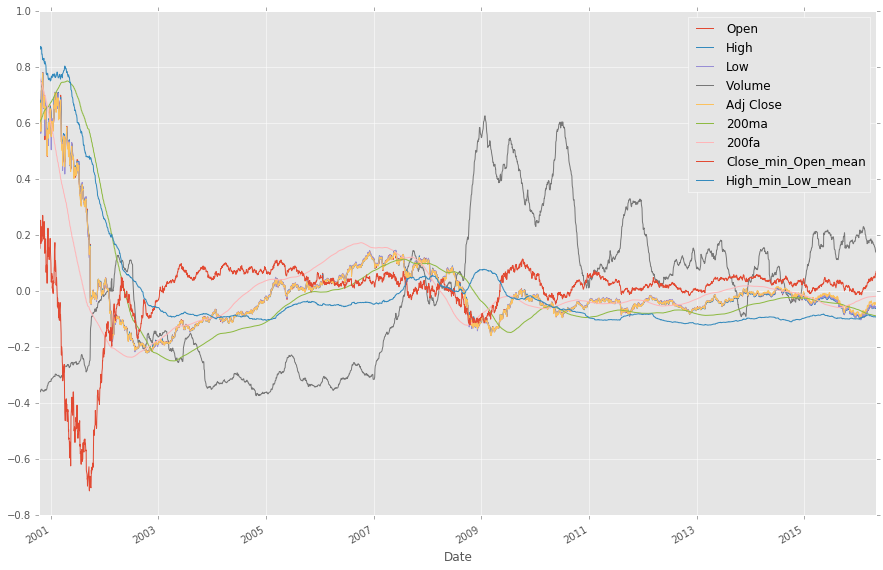

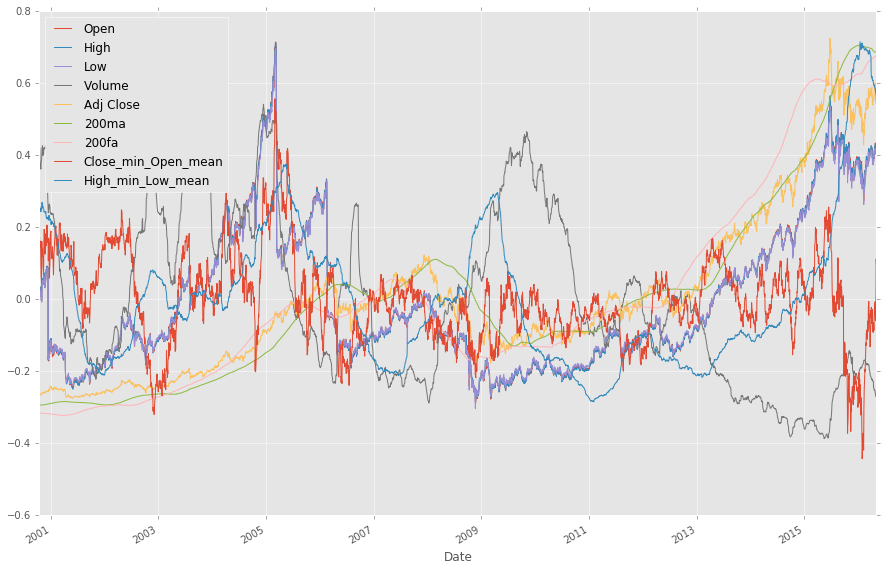

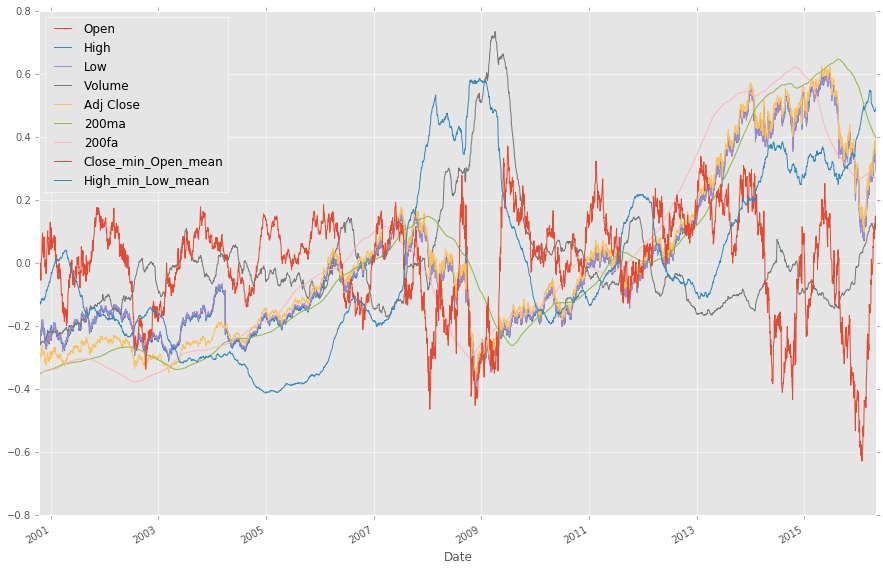

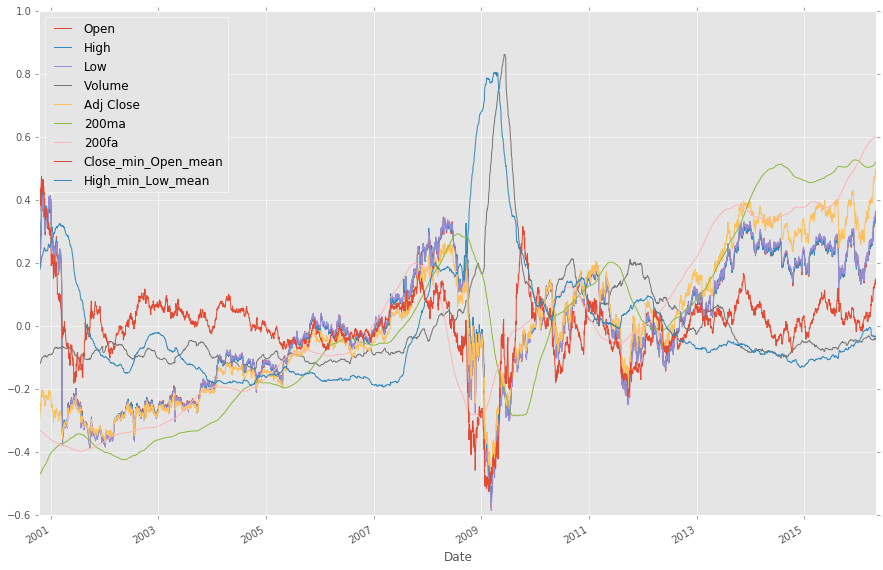

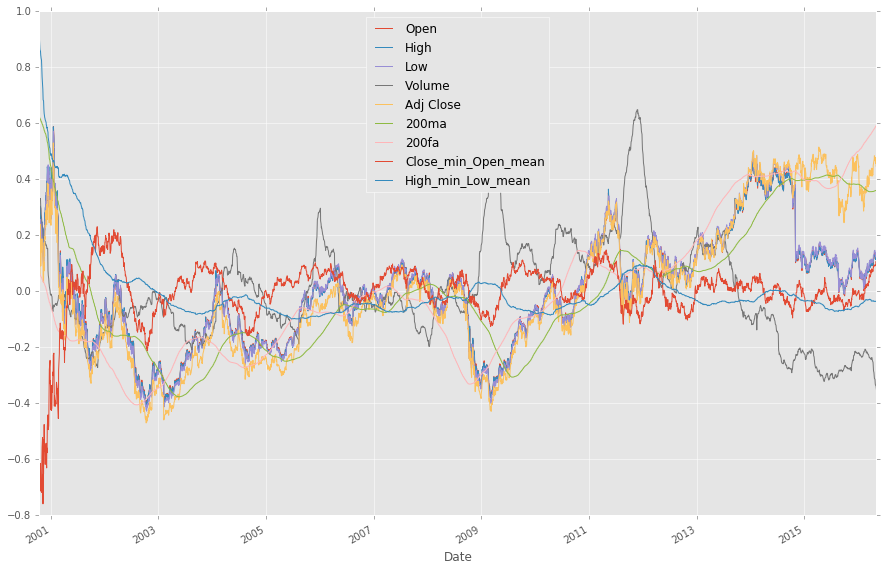

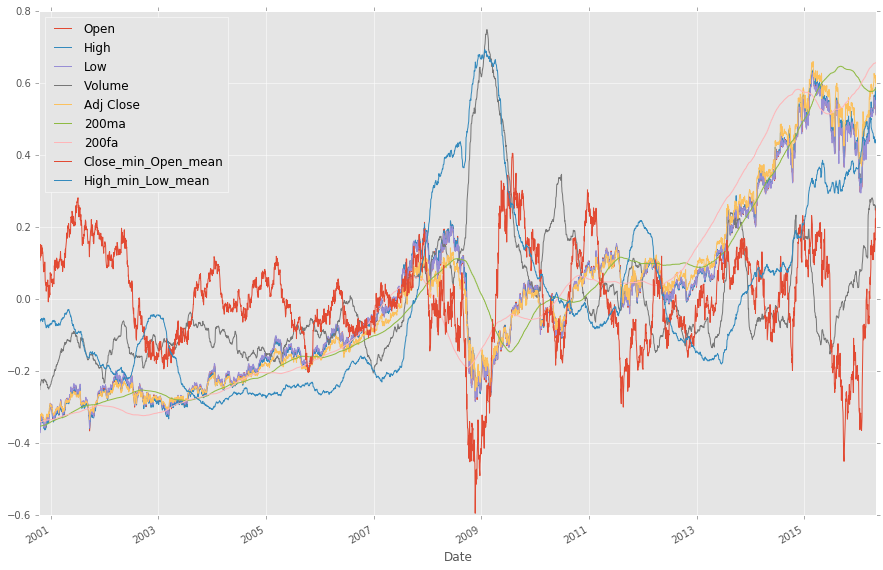

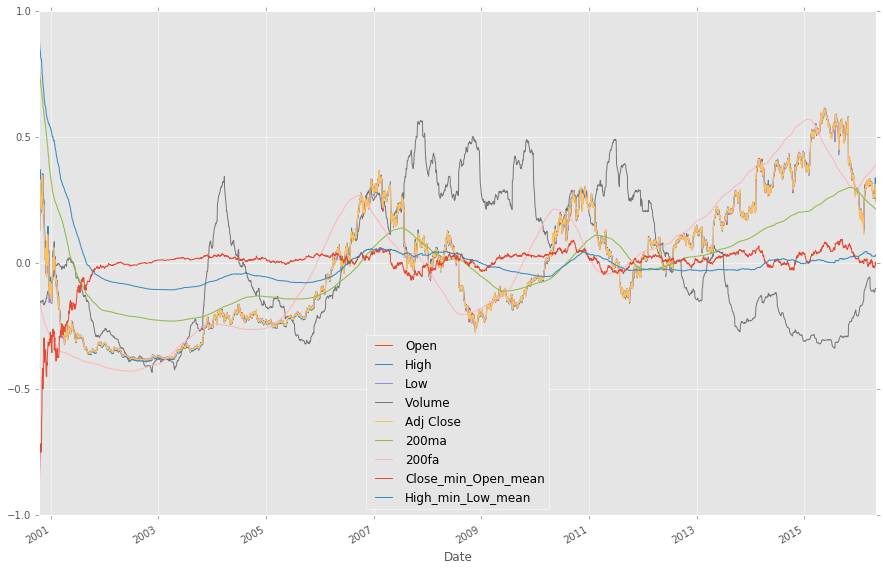

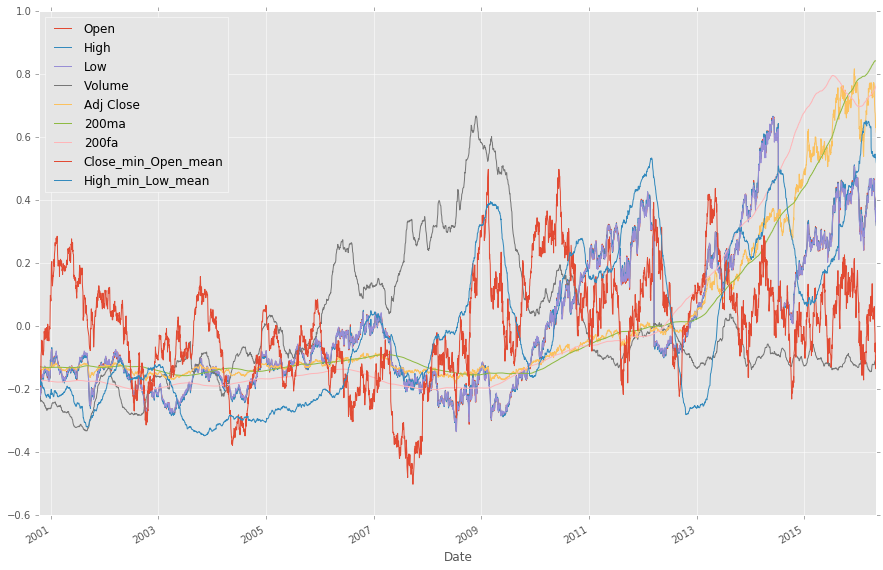

In [8]:
with open("sp500.pickle","rb") as f:
    tickers = pickle.load(f)

for st in tickers:
    if os.path.exists("stock_dfs/{}.csv".format(st)):
        df = pd.read_csv('stock_dfs/{}.csv'.format(st),parse_dates=True,index_col=0)
        df = add_ma(df)
        df.plot()
        if tickers.index(st)==15:
            break
            
plt.show()


In [36]:
def compile_data():
    with open("sp500.pickle","rb") as f:
        tickers = pickle.load(f)
    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv("stock_dfs/{}.csv".format(ticker))
            df.set_index("Date", inplace=True)
            
#             df = add_ma(df) #my func
#             df.rename(columns = {"200ma": ticker}, inplace = True)
#             df.drop(["Open","High","Low","Volume","Adj Close","200fa","Close_min_Open_mean","High_min_Low_mean"],1,inplace=True)    
            df.rename(columns = {"Adj Close": ticker}, inplace = True)
            df.drop(["Open","High","Low","Close","Volume"],1,inplace=True)
        
            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how="outer")
        
        except:
            print "err",ticker
    main_df.to_csv("sp500_joined_close.csv")
    
compile_data()        

err BRK_B
err BF_B


/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


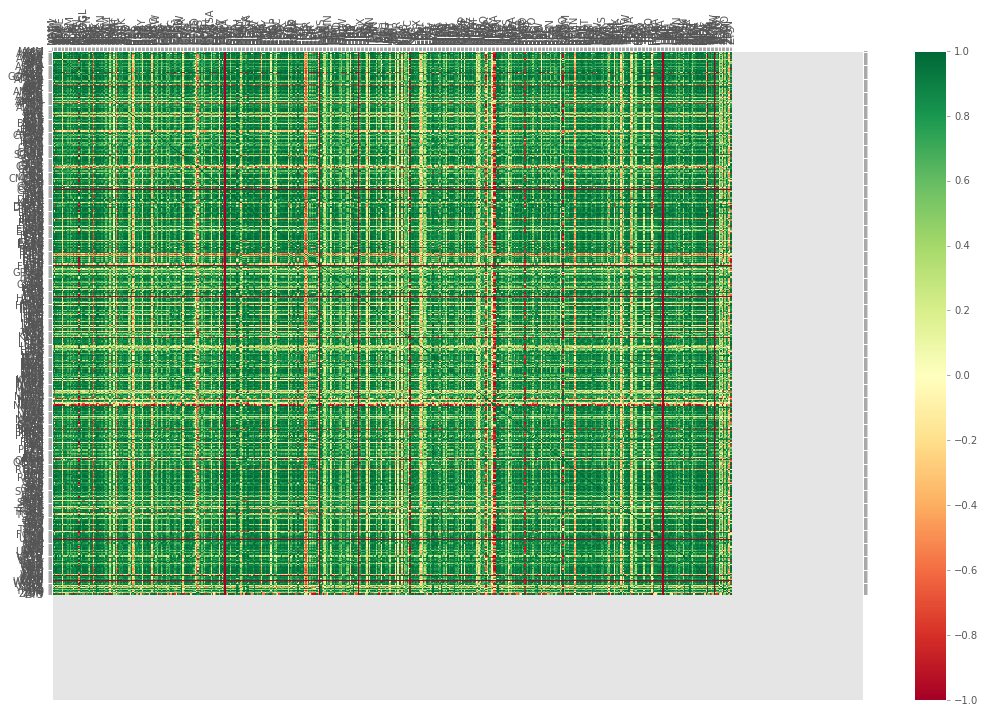

In [10]:
def visualize_data():
    df = pd.read_csv("sp500_joined_close.csv", parse_dates=True)
    df_corr = df.corr()
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0])+0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1])+0.5, minor=False)
    
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()
    
visualize_data()

In [166]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv("sp500_joined_close.csv")
    tickers = df.columns.values.tolist()
    df.fillna(0,inplace=True)
    
    # "Look into the future"
    for i in range(1,hm_days+1):
        df["{}_{}d".format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
     
    df.fillna(0, inplace=True)
    return tickers,df

process_data_for_labels('MMM')


(['Date',
  'MMM',
  'ABT',
  'ABBV',
  'ACN',
  'ATVI',
  'AYI',
  'ADBE',
  'AAP',
  'AES',
  'AET',
  'AMG',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'AGN',
  'LNT',
  'ALXN',
  'ALLE',
  'ADS',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AEE',
  'AAL',
  'AEP',
  'AXP',
  'AIG',
  'AMT',
  'AWK',
  'AMP',
  'ABC',
  'AME',
  'AMGN',
  'APH',
  'APC',
  'ADI',
  'ANTM',
  'AON',
  'APA',
  'AIV',
  'AAPL',
  'AMAT',
  'ADM',
  'ARNC',
  'AJG',
  'AIZ',
  'T',
  'ADSK',
  'ADP',
  'AN',
  'AZO',
  'AVB',
  'AVY',
  'BHI',
  'BLL',
  'BAC',
  'BK',
  'BCR',
  'BAX',
  'BBT',
  'BDX',
  'BBBY',
  'BBY',
  'BIIB',
  'BLK',
  'HRB',
  'BA',
  'BWA',
  'BXP',
  'BSX',
  'BMY',
  'AVGO',
  'CHRW',
  'CA',
  'COG',
  'CPB',
  'COF',
  'CAH',
  'HSIC',
  'KMX',
  'CCL',
  'CAT',
  'CBG',
  'CBS',
  'CELG',
  'CNC',
  'CNP',
  'CTL',
  'CERN',
  'CF',
  'SCHW',
  'CHTR',
  'CHK',
  'CVX',
  'CMG',
  'CB',
  'CHD',
  'CI',
  'XEC',
  'CINF',
  'CTAS',
  'CSCO',
  'C',
  'C

In [1]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    req = 0.015
    for col in cols:
        if col>0.0:
            return 1 #buy
        elif col<-0.0:
            return 0#-1 #Sell
    return 0 #Hold

In [2]:
def extract_featureset(ticker):
    hm_days = 7
    tickers, df = process_data_for_labels(ticker)
    
    df["{}_target".format(ticker)] = list(map(buy_sell_hold, *[df["{}_{}d".format(ticker, i)] for i in range(1, hm_days+1)]))
    
    vals = df["{}_target".format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print("Data spread", Counter(str_vals))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
        
#     df['ABT'] = df['ABBV'].pct_change()
#     print df.head()
#     print df[[ticker for ticker in tickers[1:]]]
    
#     print df[ticker]    
#     print df[ticker].pct_change()
    
    df_vals = df[[tick for tick in tickers[1:]]].pct_change()    
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    X = df_vals.values #percent change
    Y = df["{}_target".format(ticker)].values #decision

    return X, Y, df 
    
extract_featureset('MMM')

NameError: global name 'process_data_for_labels' is not defined

In [223]:
# X - % change for all the stocks
# Y - decision (manually set)    
def do_ml(ticker, pre_fit = False):
    X,y,df = extract_featureset(ticker)
        
#     X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.25)
    
    X_train = X[:(0.75*len(X))]
    y_train = y[:(0.75*len(y))]
    X_test = X[(0.75*len(X)):]
    y_test = y[(0.75*len(y)):]
    
    
#     clf = neighbors.KNeighborsClassifier()
    clf = VotingClassifier([("lsvc",svm.LinearSVC()),
                         ("knn",neighbors.KNeighborsClassifier()),
                         ("rfor",RandomForestClassifier())])
    
    if pre_fit:
        print "prefit"
        clf = pre_fit
    else:
        pre_fit = clf.fit(X_train, y_train)
    
    confidence = clf.score(X_test, y_test)
    prediction = clf.predict(X_test)
    
    print "prediction:", Counter(prediction)
    print "Accuracy:", confidence
    
    return confidence, pre_fit
    
_,pt = do_ml("BAC")
do_ml("AAPL", pt)
do_ml("AAPL")
do_ml("GOOG", pt)
do_ml("GOOG")
0

('Data spread', Counter({'0': 2691, '1': 1619}))


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


prediction: Counter({0: 1034, 1: 44})
Accuracy: 0.599257884972
('Data spread', Counter({'0': 2434, '1': 1876}))
prefit
prediction: Counter({0: 1034, 1: 44})
Accuracy: 0.609461966605
('Data spread', Counter({'0': 2434, '1': 1876}))
prediction: Counter({0: 698, 1: 380})
Accuracy: 0.550092764378
('Data spread', Counter({'0': 2990, '1': 1320}))
prefit
prediction: Counter({0: 1032, 1: 44})
Accuracy: 0.617100371747
('Data spread', Counter({'0': 2990, '1': 1320}))
prediction: Counter({0: 981, 1: 95})
Accuracy: 0.614312267658


0